In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Set random_state 
random_state = 1

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
Merged = pd.read_pickle("../data/trainable.pkl")

In [3]:
len(Merged)

43607

# Exploratory Data Analysis

Now the fun begins! We are left with 16 Raw Features (and 2 previously engineered features), and 1 Target Variable, as follows:

## Categories of Features
- #### Numerical Variables
    - *Discrete*
        1. **Yards to Go** - Yards to gain a first down (or to goalline)
        2. **Time left in Quarter** - Time, in minutes and seconds, left in the current quarter
    - *Continuous*
        3. **Pre-Snap Cushion** - distance between the receiver and the defender who lines up across from them at snap (yds)
        4. **Air Yards** - vertical distance down the field a receiver is when the pass arrives
        5. **Air Distance** - straight line distance from the QB to the targeted recevier when the pass arrives (yds)
        6. **Air Time** - time the pass is in the air (in seconds)
        7. **TTT** - time from when the ball is snapped to when it is thrown (in seconds)
        8. **QB Separation** - distance from the QB to the nearest defender to the QB at the time of pass (in seconds)
        9. **Receiver Dist from Sideline** - distance from targeted receiver and nearest sideline when pass arrives (yds)
        10. **Endzone Dist** - the distance a reciever is from the back of the nearest endzone (yds)
        11. **QBP** - A binary value (1 or 0) that indicates if the QB was pressured 
        12. **QB Scramble Yards** - The distance the QB travels on a play before throwing the pass
- #### Categorical
   - *Non-Ordinal*
        13. **Position of Nearest Defender** - SS, OLB, DL, CB
        14. **Pre-Snap Receiver Location** - Wide, Slot, Tight
   - *Ordinal*
        15. **Quarter**
        16. **Down**

        
Lets create a correlation heatmap to see how linearly correlated these features are with Receiver Separation:
      

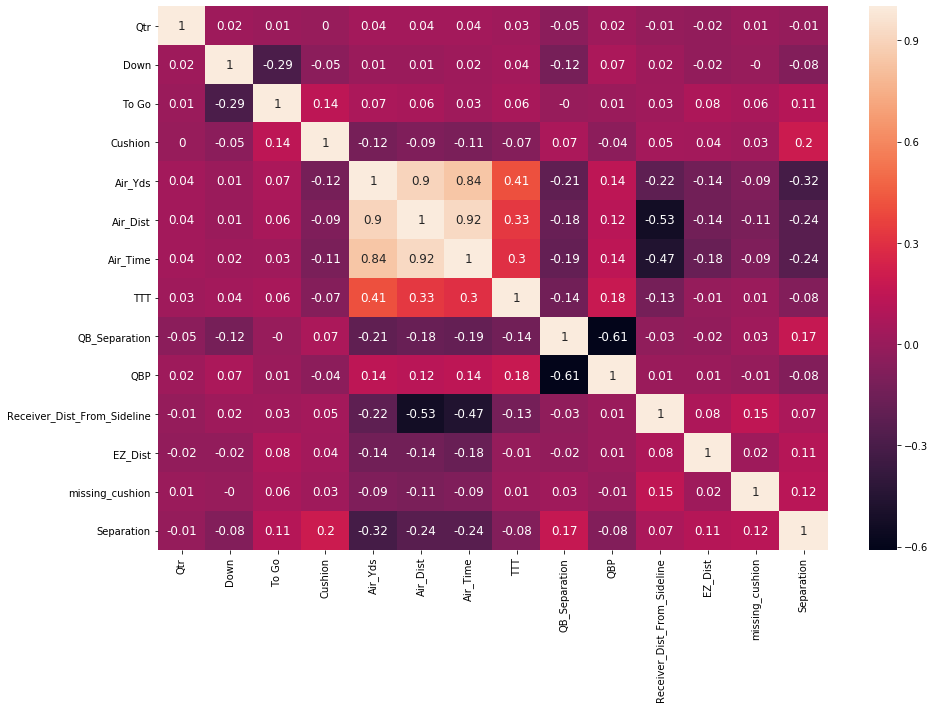

In [4]:
fig =  plt.subplots(figsize=(15,10))
ax = sns.heatmap(round(Merged.corr(method = 'pearson'), 2), annot=True, annot_kws={"size": 12})

If we look at the bottom row of the heatmap, we can see than **Air Yards** seems to be most correlated to Separation (r = -.32). 

## Addressing Multicollinearity in Features

Before we move on to dive into each feature, we need to make sure that our features are not collinear. Althought multicollinearity is not inherently bad for the accuracy of predictions, it may affect how the independent variables are valued by our model, which can be detrimental to the intrepretability of the model itself. It is worth noting, that addressing multicollinearity is a choice I am making to make our model simpler, but isn't always necessary. 

>"The fact that some or all predictor variables are correlated among themselves does not, in general, inhibit our ability to obtain a good fit nor does it tend to affect inferences about mean responses or predictions of new observations.  
>>—Applied Linear Statistical Models, p289, 4th Edition."

Since this model is intended for fans, analysts, and scouts alike, interpretability is of the utmost importance. 

As we can see in the Heatmap above, the most collinear features are Air Yards, Air Time, and Air Distance. Since Air Yards is most correlated to the target variable (Separation), I will keep it. Air Distance and Air Time have the same correlation to our target variable (-.24), so I will look to remove the variable which is most collinear to Air Yards, which, in this case, is Air Distance (.90 correlation to Air Yards vs .84 for Air Time and Air Yards). 


In [5]:
#dropping air distance
Merged = Merged.drop('Air_Dist', axis = 1)

## Feauture Analysis: Quarter

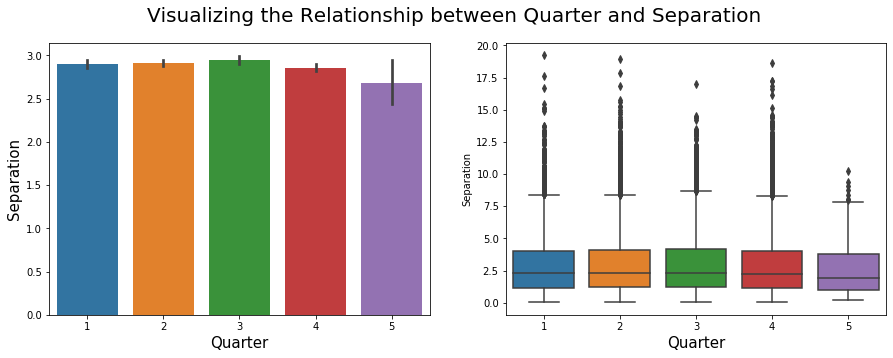

In [6]:
# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Qtr', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Qtr', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Quarter', fontsize=15)
ax2.set_xlabel('Quarter', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)

In [7]:
Qtr_df = Merged[['Qtr', 'Separation']]
Qtr_df.groupby(['Qtr']).mean().round({'Separation': 2}).sort_values('Qtr', ascending = True)

,Separation
Qtr,
1,2.90
2,2.91
3,2.95
4,2.86
5,2.69


Just by looking at these distributions, I cannot tell whether quarter has any discernable affect on Separation, especially within a regulation game. 

It looks like passes in overtime (the 5th quarter, in this case) have the lowest average separation, which makes sense, as the stakes are the highest. That said, before I decide to include/remove the feature, I want to run some t-tests to see if the distributions are statistically different from each other. In other words, is the fact that the average separation for targets in regulation (quarters 1-4) higher than targets in overtime (quarter 5) significant? Or could this happen with any random subestting of data distributed like this? 

## Feature Engineering - 'Is Overtime' 

I am going to separate all regulation Separations (quarters 1-4) with overtime (quarter 5) to prep my t-test:

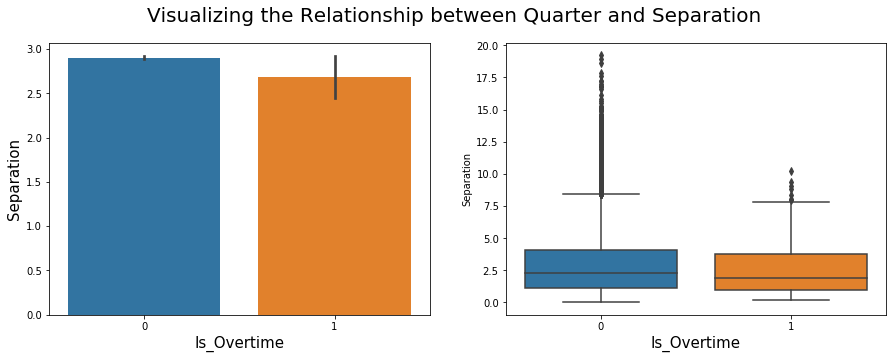

In [8]:
#Create new columns called 'Is_Overtime' that is 1 in overtime and 0 in all other quarter
Test = Merged.copy()

Test['Is_Overtime'] = 0
Test.loc[Test['Qtr'] == 5, 'Is_Overtime'] = 1

# Show some plots to visualize relationship beteen Quarter and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Quarter and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Is_Overtime', y='Separation', data=Test, ax = ax1) 
sns.boxplot(x='Is_Overtime', y='Separation', data=Test, ax = ax2)

ax1.set_xlabel('Is_Overtime', fontsize=15)
ax2.set_xlabel('Is_Overtime', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)


In [9]:
rvs1 = Test[Test['Is_Overtime'] == 0]['Separation']
rvs2 = Test[Test['Is_Overtime'] == 1]['Separation']

p_value = round(stats.ttest_ind(rvs1,rvs2)[1], 5)

print('Our p value is ' + str(p_value))
print('Since our p value > 0.05, we cannot reject the null hypothesis, the two disributions are statistically indiscernable.')

Our p value is 0.11145
Since our p value > 0.05, we cannot reject the null hypothesis, the two disributions are statistically indiscernable.


It's close, but because of our p value is not less than .05, I will **NOT** include 'Is_Overtime in my modeling/features selection process.

# Feature Analysis: Down

Text(0, 0.5, 'Separation')

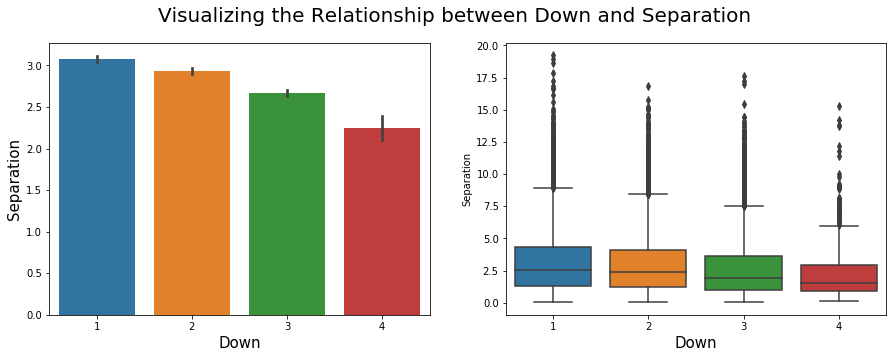

In [10]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='Down', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='Down', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Down', fontsize=15)
ax2.set_xlabel('Down', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)

In [11]:
Down_df = Merged[['Down', 'Separation']]
Down_df.groupby(['Down']).mean().round({'Separation': 2}).sort_values('Down', ascending = True)

,Separation
Down,
1,3.08
2,2.93
3,2.67
4,2.25


There seems to be a correlation between what down it is and the average separation of the targeted receiver. This isn't too surprising, as we would expect defenses to play more closely in more high-stakes/important downs. 

Nothing more needs to be done here, we will keep Down in the data set and move on.

# Feature Analysis: Yards to Go

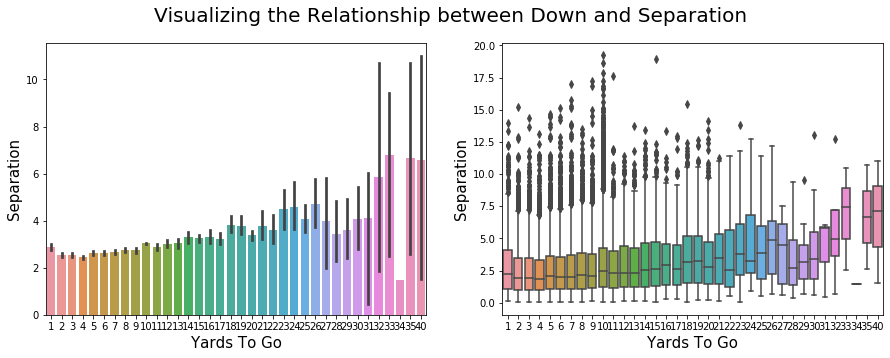

In [12]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='To Go', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='To Go', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go', fontsize=15)
ax2.set_xlabel('Yards To Go', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
A = ax2.set_ylabel('Separation', fontsize=15)

As we saw above, the correlation coefficient of raw 'Yards To Go' to 'Separation' was 0.11. 

Instead of having 40 unqiue 'To Go' values, I am going to bin certain 'Yards To Go' values into a new category called 'YTG_Bin' or 'Yards To Go Binned.' There will be 4 categories - **Short** (1-4), **Medium** (5-9), **Long** (10), and **Longest** (10+) - in an effort to see if it helps create a higher correlations value or help in predictions. The value of 1 corresponds to Short, and 4 corresponds to Longest.

In [13]:
Merged['YTG_Bin'] = 0

def Create_YTG_Bins(row):
    #Short
    if row <= 4:
        return 'Short'
    
    #Medium
    elif (row >=5 and row <= 9):
        return 'Medium'
    
    #Long
    elif row == 10:
        return 'Long'
    
    #Anything over 10 Yards is Longest!
    elif row > 10:
        return 'Longest'
    
Merged['YTG_Bin'] = Merged['To Go'].apply(Create_YTG_Bins)

In [14]:
YTG_df = Merged.groupby('YTG_Bin').agg(Avg_Sep = ('Separation', 'mean'),Targets = ('Separation', 'size'))
YTG_df = YTG_df.round({'Avg_Sep': 2}).sort_values('Avg_Sep', ascending = False)
YTG_df

,Avg_Sep,Targets
YTG_Bin,,
Longest,3.26,6172
Long,3.03,19211
Medium,2.68,11843
Short,2.56,6381


Roughly 44% of all plays in this data set have 10 yards to go, so I split the data as I did in order to try and get as equal a split of plays in each category. 

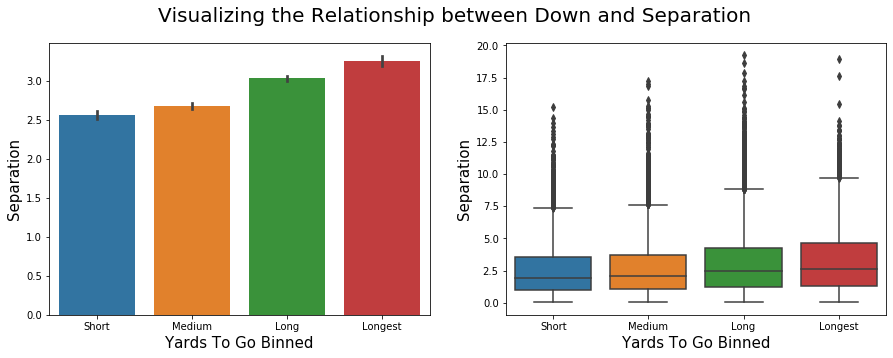

In [15]:
fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Visualizing the Relationship between Down and Separation', fontsize=20)

Merged = Merged.sort_values('To Go')

    # Draw the density plots
sns.barplot(x='YTG_Bin', y='Separation', data=Merged, ax =ax1) 
sns.boxplot(x='YTG_Bin', y='Separation', data=Merged, ax = ax2)

ax1.set_xlabel('Yards To Go Binned', fontsize=15)
ax2.set_xlabel('Yards To Go Binned', fontsize=15)
ax1.set_ylabel('Separation', fontsize=15)
A = ax2.set_ylabel('Separation', fontsize=15)

# Feature Engineering: Down & Distance

Now that we have looked at 'Down' and 'Yards to Go' already, I want to combine them to create a 'Down & Distance' feature. Each of these features alone does not seem to have a lot predictive power, but combined, perhaps they will be more helpful. 

In [16]:
Merged['Down_Distance'] = ''
Merged['Down_Distance'] = Merged['Down'].astype(str) + '&' + Merged['YTG_Bin']

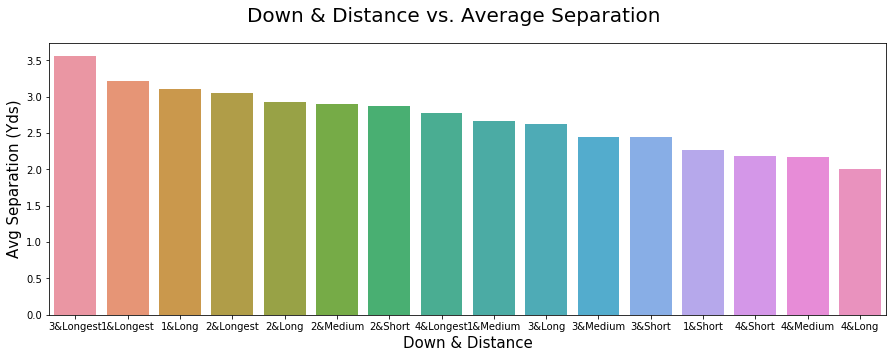

In [17]:
D_D_df = Merged[['Down_Distance', 'Separation']]
dddf = D_D_df.groupby(['Down_Distance']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False).reset_index()
dddf['Play_Counts'] = D_D_df.groupby(['Down_Distance']).count().round({'Separation': 2}).sort_values('Separation', ascending = False)

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Down & Distance vs. Average Separation', fontsize=20)
sns.barplot(x='Down_Distance', y = 'Separation', data = dddf)

ax.set_xlabel('Down & Distance', fontsize=15)
A = ax.set_ylabel('Avg Separation (Yds)', fontsize=15)


# Feature Analysis: Cushion

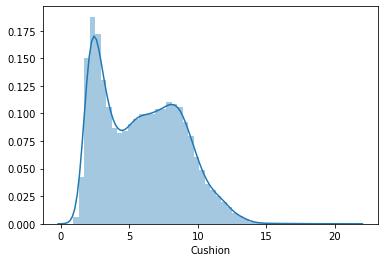

In [18]:
fig = sns.distplot(Merged['Cushion'])

I am noticing the **Bimodal** nature of this distribution, suggesting that defenders usually either line up close to the receiver (think Press coverage), or quite far off of them (Off coverage). From this, I want to further look into how these two types of cushion relate to the recievers separation

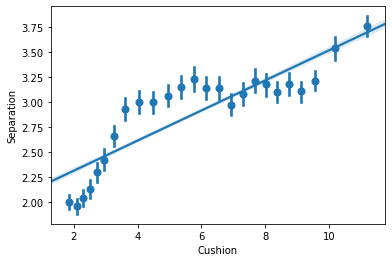

In [19]:
y = Merged['Separation']
x = Merged['Cushion']
p1 = sns.regplot(x=x, y=y, data=Merged, x_bins = 25)

## Feature Engineering: Cushion_Type

Seen in the binned scatter plot above, we can see that, on the whole, an increase in cushion leads (or at least is linearly correlated to) an increase in separation, up until about 3 yards of cushion. I will create a new feature called 'Press_Cushion' that is equal to 1 when they are 'pressed' at the line of scrimmage (< 3 yards) 0 when lining up 3-9 yards away, and set to 2 when 9+ yards away.

In [20]:
Merged['Cushion_Type'] = 'Regular'
Merged['Cushion_Type'].loc[Merged['Cushion'] <= 3] = 'Press'
Merged['Cushion_Type'].loc[Merged['Cushion'] >= 9] = 'Off'
Merged.head() 

,Nearest_Def_Position,Qtr,Time,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,EZ_Dist,missing_cushion,Separation,YTG_Bin,Down_Distance,Cushion_Type
51974,CB,2,9:28,3,1,Wide,2.71,6.06,0.668,2.602,1.294025,1,4.333330,36.939999,0,3.614540,Short,3&Short,Press
37741,CB,4,14:20,1,1,Tight,2.67,9.70,1.214,4.488,2.992073,0,6.463331,1.300000,0,1.223315,Short,1&Short,Press
2336,CB,1,5:03,3,1,Slot,2.31,23.08,2.069,2.213,3.518892,0,4.593328,52.919998,0,0.384708,Short,3&Short,Press
37742,CB,4,14:14,2,1,Wide,3.14,6.25,1.989,1.142,1.969772,1,2.783331,4.750000,0,1.276127,Short,2&Short,Regular
3538,FS,2,15:00,3,1,Tight,6.20,3.99,1.067,3.137,4.660097,0,22.063330,30.010002,0,11.414131,Short,3&Short,Regular


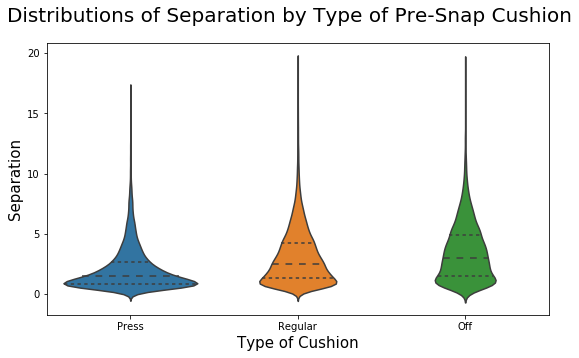

In [21]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig = plt.figure(figsize=(9,5))

sns.violinplot(x="Cushion_Type", y="Separation", data=Merged, inner = 'quartile')

plt.suptitle('Distributions of Separation by Type of Pre-Snap Cushion', fontsize = 20)
plt.ylabel('Separation', fontsize = 15)
A = plt.xlabel('Type of Cushion', fontsize = 15)

In [22]:
Pressed = Merged[['Cushion_Type', 'Separation']]
Pressed.groupby(['Cushion_Type']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)

,Separation
Cushion_Type,
Off,3.46
Regular,3.06
Press,2.11


Players who were pressed at the line of scrimmage (less than 3 yards of pre-snap cushion) saw roughly **a yard of separation less** at pass arrival than receivers who were not pressed. 

To confirm, look at the overlaid distributions below to see how receivers who are pressed perform differently to those who are not pressed.

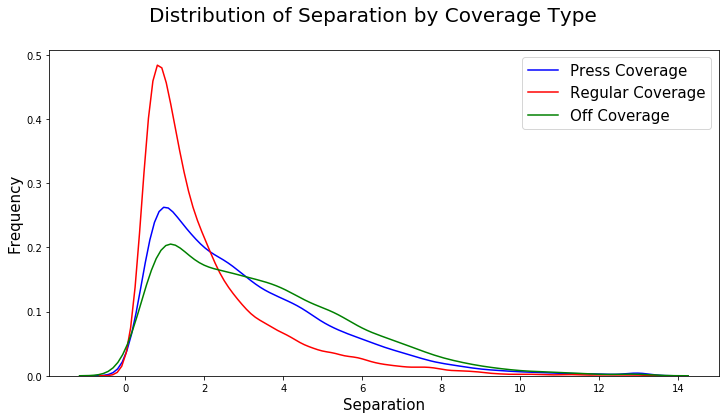

In [23]:
# List of three types of cushion types
Coverage_Types = ['Press Coverage', 'Regular Coverge', 'Off Coverage']

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distribution of Separation by Coverage Type', fontsize = 20)

sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 'Regular'].clip(upper = 13) , color="blue", label="Press Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 'Press'].clip(upper = 13) , color="red", label="Regular Coverage", hist = False)
sns.distplot( Merged['Separation'].loc[Merged['Cushion_Type'] == 'Off'].clip(upper = 13), color = 'green', label = 'Off Coverage', hist = False)
    
# Draw the density plots
ax.legend(loc=1, prop={'size': 15})
ax.set_ylabel('Frequency', fontsize = 15)
plt.xticks(range(-0, 15, 2))
A = ax.set_xlabel('Separation', fontsize = 15)

# Feature Analysis: Air Yards

**Air Yards** - the distance a pass is from the line of scrimmage, and can be negative if the pass is thrown to a reciever behind the line of scrimmage

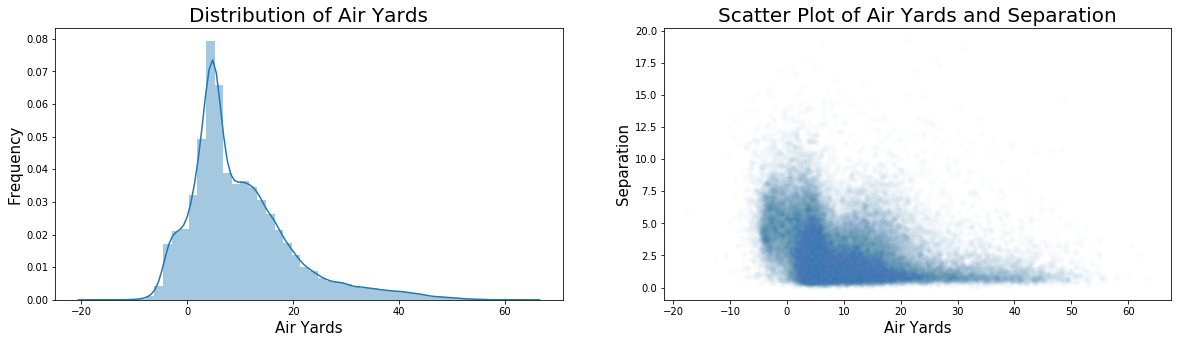

In [24]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Yards', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Yards', fontsize = 15)

ax2.set_title('Scatter Plot of Air Yards and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Air Yards', fontsize = 15)

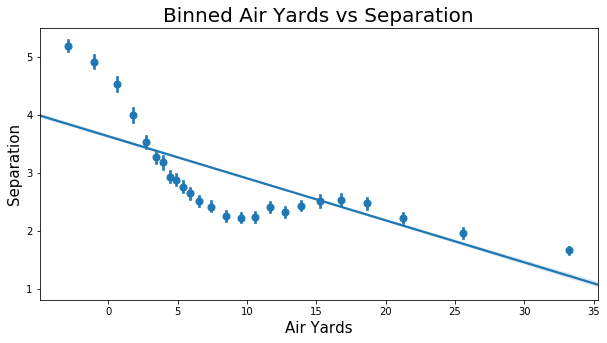

In [25]:
x = Merged['Air_Yds']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 25)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Air Yards', fontsize = 15)

This looks approximately linear, but I think **log transform** to the data will help with prediction. I will address this at the end of this data analysis process (bottom of this page).

# Feature Analysis: Air Time

**Air Time** - the the time from the ball is released for the pass to the time the pass arrives to the targeted receiver. 

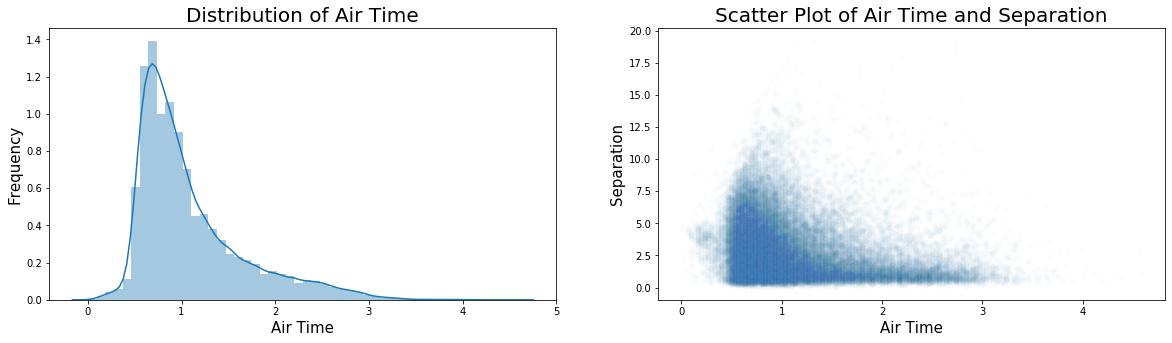

In [26]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Air Time', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Air Time', fontsize = 15)

ax2.set_title('Scatter Plot of Air Time and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Air Time', fontsize = 15)

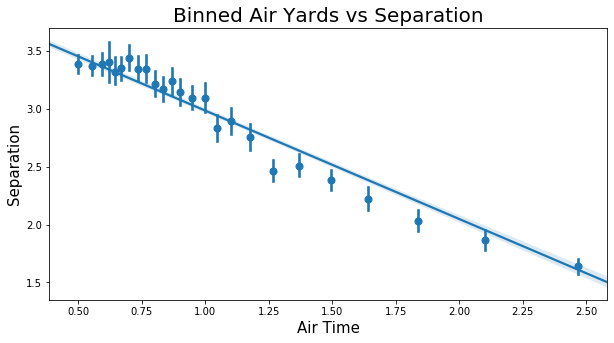

In [27]:
x = Merged['Air_Time']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 25)

ax.set_title('Binned Air Yards vs Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Air Time', fontsize = 15)

In [28]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Air Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Air Time and Separation')

Spearman (rank) correlation: -0.273 between Air Time and Separation
Pearson (linear) correlation: -0.238 between Air Time and Separation


# Feature Analysis: QB Separation

**QB Separation** - The distance between the QB and the nearest defender (usually a pass rusher) to the QB at the time the pass in thrown.

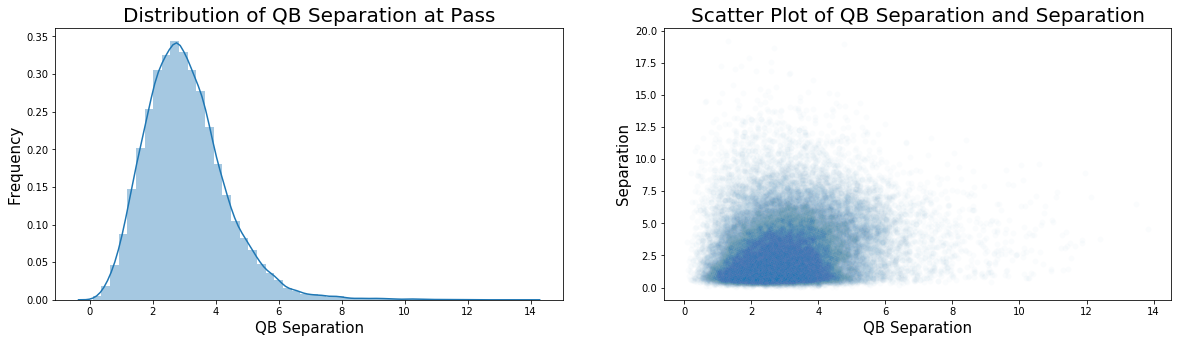

In [29]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))


sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of QB Separation at Pass', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('QB Separation', fontsize = 15)

ax2.set_title('Scatter Plot of QB Separation and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

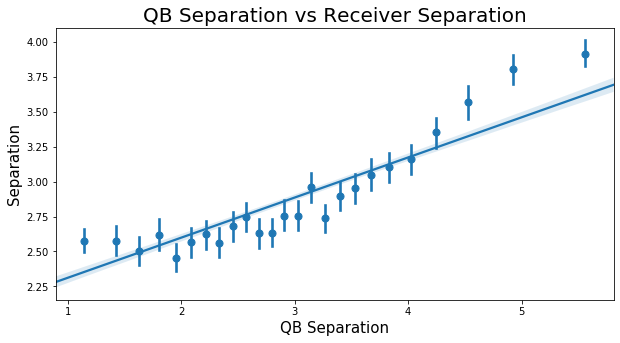

In [30]:
x = Merged['QB_Separation']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 25)

ax.set_title('QB Separation vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('QB Separation', fontsize = 15)

This binned plot above describes a rough linear correlation between separation and QB separation. This would suggest that when QBs are under pressure, they cannot deliver an accurate pass, and therefore their receiver's separation is lower. 

# Feature Analysis: Receiver Distance from Sideline as Pass Arrival

This feature quantifies the distance (in yards) from the targeted receiver and the nearest sideline at the time pass arrives. 

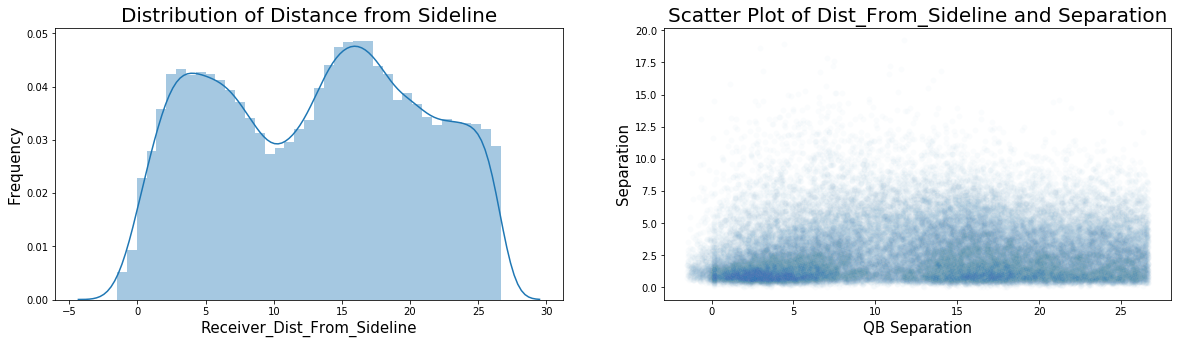

In [31]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Distance from Sideline', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Receiver_Dist_From_Sideline', fontsize = 15)

ax2.set_title('Scatter Plot of Dist_From_Sideline and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('QB Separation', fontsize = 15)

In the graph above, we see the distribution is non-normal, slightly bimodal, with most passes arriving 15 yards from the sideline or 5 yards from the sideline. Negative values here indicate that the receiver was out of bounds by the time the pass arrived. It is possible that 

In [32]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Sideline Distance and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Sideline Distance and Separation')

Spearman (rank) correlation: 0.101 between Sideline Distance and Separation
Pearson (linear) correlation: 0.067 between Sideline Distance and Separation


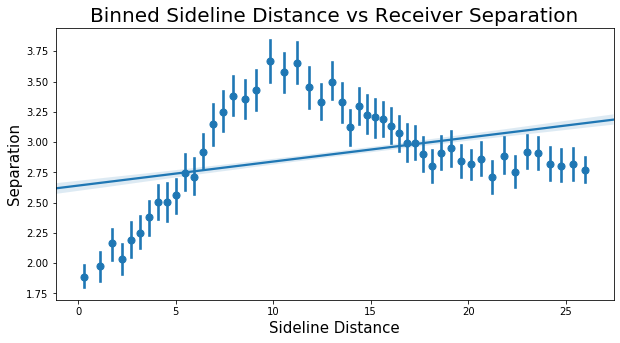

In [33]:
x = Merged['Receiver_Dist_From_Sideline']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned Sideline Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Sideline Distance', fontsize = 15)

Average Separation decreases steadily once the receiver gets 10 yards away from the sideline. 

I am going to create a new feature, called 'is_near_sideline' that is equal to 0 when a receiver is more than 5 yards from the sideline at target, and equal to the sideline distance when the player is within 5 yards of the sideline to try and distinguish these types of situations.

# Feature Engineering: 'is_near_sideline'

In [34]:
Merged['is_near_sideline'] = 0
Merged['is_near_sideline'].loc[Merged['Receiver_Dist_From_Sideline'] <= 5] = 1
A = np.count_nonzero(Merged['is_near_sideline'])
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the sideline, or ' + str(C) + '% of all plays')

8535 of 43607 targets were within 5 yards of the sideline, or 19.6% of all plays


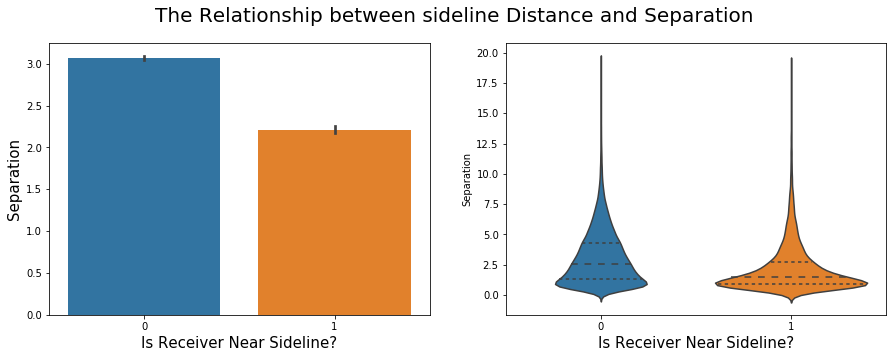

In [35]:
# Show some plots to visualize relationship between Sideline Distance and Separation

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('The Relationship between sideline Distance and Separation', fontsize=20)

    # Draw the density plots
sns.barplot(x='is_near_sideline', y='Separation', data=Merged, ax = ax1) 
sns.violinplot(x='is_near_sideline', y='Separation', data=Merged, ax = ax2, inner = 'quartile')

ax1.set_xlabel('Is Receiver Near Sideline?', fontsize=15)
ax2.set_xlabel('Is Receiver Near Sideline?', fontsize=15)
A = ax1.set_ylabel('Separation', fontsize=15)

# Feature Analysis: Distance Receiver is from Back of Endzone

This feature is defined as the distance (in yards) that there recevier is from the back of the endzone (in the direction the play is facing). 

My initial thought is that this feature will be noise until the receiver gets within some yardage from the back of the endzone, and then get lower as it endzone distance goes to 0. 

For refence, EZ_distance does not get higher than 60 because it is not tracked until a receier crosses midfield (which is 60 yards from back of endzone)

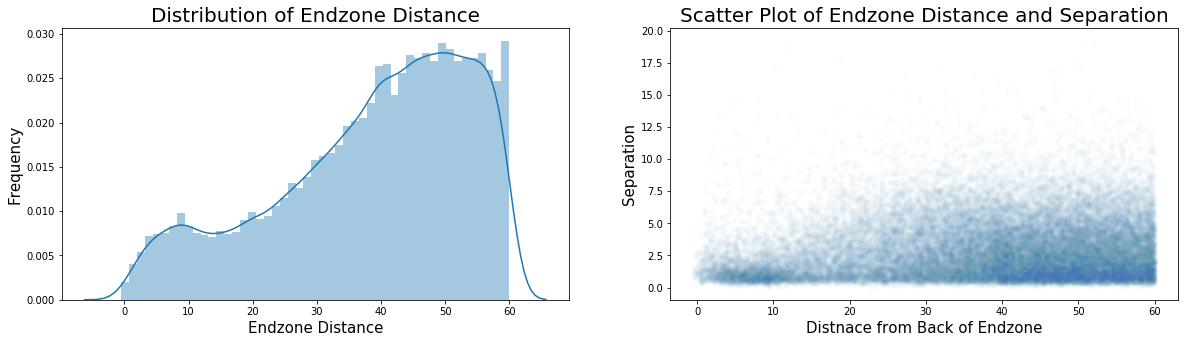

In [36]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Endzone Distance', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Endzone Distance', fontsize = 15)

ax2.set_title('Scatter Plot of Endzone Distance and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Distnace from Back of Endzone', fontsize = 15)

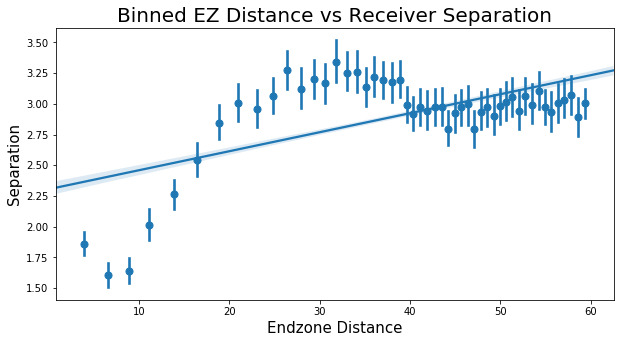

In [37]:
x = Merged['EZ_Dist']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 50)

ax.set_title('Binned EZ Distance vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Endzone Distance', fontsize = 15)

# Feature Engineering: Receiver Within 5 yard line?

Create binary value that is 1 when the target receiver is within 5 yards of the goalline (or 15 yards from the back of the endzone) and 0 everywhere else.

In [38]:
Merged['Inside_5YardLine'] = 0
Merged['Inside_5YardLine'].loc[Merged['EZ_Dist'] <= 15] = 1
A = Merged['Inside_5YardLine'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets were within 5 yards of the goal line, or ' + str(C) + '% of all plays')

4650 of 43607 targets were within 5 yards of the goal line, or 10.7% of all plays


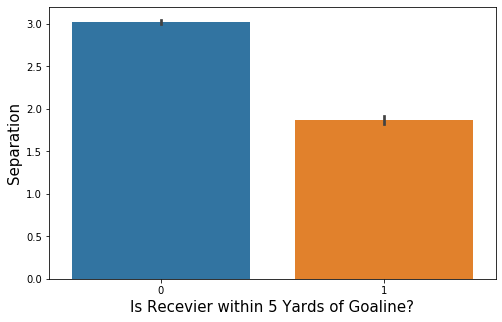

In [39]:
x = Merged['Inside_5YardLine']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Is Recevier within 5 Yards of Goaline?', fontsize = 15)

Receivers are allowed _more than yard more_ of separation when they are **NOT** within 5 yards of the goalline (15 yards from the back of the endzone)

# Categorical Features

## Position of Nearest Defender

In [40]:
Pos_df = Merged[['Nearest_Def_Position', 'Separation']]
Position = Pos_df.groupby(['Nearest_Def_Position']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Position['Play_Counts'] = Pos_df.groupby(['Nearest_Def_Position']).count()
Position

,Separation,Play_Counts
Nearest_Def_Position,,
NT,5.13,115
DE,5.12,878
DT,5.02,625
DL,4.50,17
OLB,3.69,3327
LB,3.66,1511
MLB,3.36,1518
ILB,3.34,2598
WR,3.24,16


It looks there are a lot of different positions listed here, but 20K plays belong just to CBs. I don't think there is much difference between positions like OLB and ILB, as well as DL vs DE vs DT. To this end, I will consolidate these categories to make it simpler to understand. Also, it looks like a few offensive skill players have been used on defense occasionally. Since they represent ~20 rows, I am going to drop them.

In [41]:
# Dropping all rows where skill position players that were the ones who were the nearest defender at pass arrival
skillpos = ['WR', 'TE', 'FB', 'RB', 'QB']
Merged = Merged[~Merged['Nearest_Def_Position'].isin(skillpos)]

## Feature Engineering: Clean up Defender Position Categories

In [42]:
LB = ['OLB', 'ILB', 'MLB', 'LB']
DL = ['DL', 'DE', 'DT', 'NT']
CB = ['CB', 'DB']
SAFE = ['SAF', 'S', 'FS', 'SS']

def NearestPos(row):
    
    #LBs
    if row in LB:
        return 'LB'
    
    #DLs
    elif row in DL:
        return 'DL'
    
    #CBs
    elif row in CB:
        return 'CB'
    
    #Safeties
    elif row in SAFE:
        return 'STY'
    else:
        return 'Other'
    

Merged['NDP'] = ''
Merged['NDP'] = Merged['Nearest_Def_Position'].copy().apply(NearestPos)    

In [43]:
NDP_df = Merged[['NDP', 'Separation']]
Pos = NDP_df.groupby(['NDP']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False)
Pos['Play_Counts'] = NDP_df.groupby(['NDP']).count()
Pos

,Separation,Play_Counts
NDP,,
DL,5.08,1635
LB,3.53,8954
STY,2.90,8165
CB,2.53,24834


# Feature: Pre-Snap Receiver Location

This is what we covered a bit in earlier analysis, but this is broken down into 3 (previously 4, before _backfield_ was removed) categories:
- Wide
- Slot
- Tight

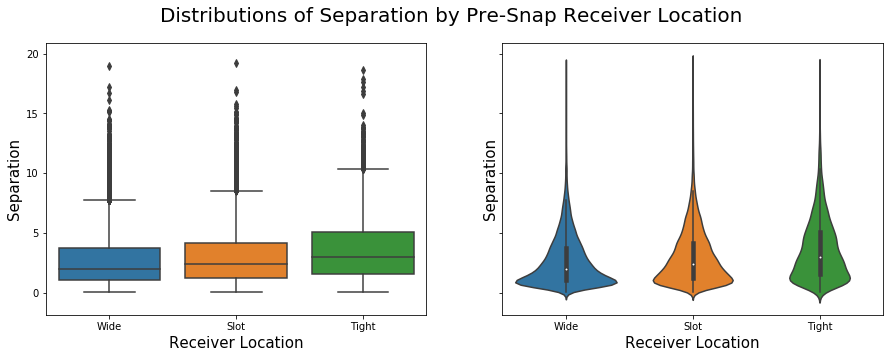

In [44]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))


sns.boxplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax1, order = ['Wide', 'Slot', 'Tight'])
sns.violinplot(x="Receiver_Location", y="Separation", data=Merged, ax = ax2, order = ['Wide', 'Slot', 'Tight'])

fig.suptitle('Distributions of Separation by Pre-Snap Receiver Location', fontsize = 20)
ax1.set_ylabel('Separation', fontsize = 15)
ax1.set_xlabel('Receiver Location', fontsize = 15)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Receiver Location', fontsize = 15)

There are marginal differences between the distributions of these three locations, and I am going to leave them as-is. 

# Feature Analysis: Time

There are 60 minutes in an NFL football game, and I don't think there is any inherent difference that we should expect when it comes to separation when its the start of the 1st, 2nd, 3rd, or 4th quarter. I think there might be more interesting things to find, but I want to translate this MM:SS time string that I am given to an integer value of seconds left in game, and go from there.

In [45]:
def time_to_seconds(time_str):
    #Change the string 'Time' to a value in seconds
    
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)

#Quick check to make sure this function does what I am intending
print(str(Merged['Time'][3]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][3])) + ' seconds')
print(str(Merged['Time'][50]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][50])) + ' seconds')
print(str(Merged['Time'][302]) + ' is equal to ' + str(time_to_seconds(Merged['Time'][302])) + ' seconds')

6:45 is equal to 405 seconds
10:29 is equal to 629 seconds
13:46 is equal to 826 seconds


I found a bug with the function, because it didn't know how to treat 'nan' Time values. These were not found earlier because they are 'non as strings, not the Nans that pandas recognizes. Let's remove them now

! Whats happening here? ! What are these Na Values?

In [46]:
Merged['Time'] = Merged['Time'].astype(str)
Merged = Merged[Merged['Time'] != 'nan']

In [47]:
Merged['Time_in_Sec'] = Merged['Time'].apply(time_to_seconds)

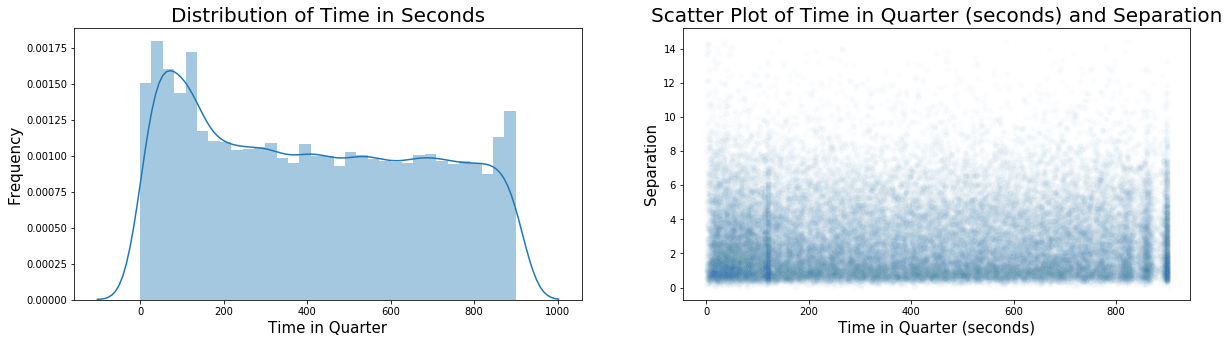

In [48]:
x = Merged['Time_in_Sec']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time in Seconds', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time in Quarter', fontsize = 15)

ax2.set_title('Scatter Plot of Time in Quarter (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time in Quarter (seconds)', fontsize = 15)

In [49]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.021 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


As you might've guessed, the time left in a quarter has almost no correlation to the separation. 

Let's do some feature engineering to see if we can get some more insight out of this feature.

# Feature Engineering: Time Left in Game/Time Left in Half

Its not enough to use just the time left in the quarter to understand how time left affects gameplay, especially receiver separation. Let's see if include Quarter into this measurement helps us understand more.

In [50]:
Merged['sec_left_in_game'] = Merged['Time_in_Sec'] + ((4-Merged['Qtr'])*15*60)


#Check to see that this is doing what we are expecting

print(str(Merged['Time'][3]) + ' in the ' + str(Merged['Qtr'][3]) + 'rd Quarter is equal to ' + str(Merged['sec_left_in_game'][3]) + ' seconds')
print(str(Merged['Time'][30]) + ' in the ' + str(Merged['Qtr'][30]) + 'th Quarter is equal to ' + str(Merged['sec_left_in_game'][30]) + ' seconds')
print(str(Merged['Time'][302]) + ' in the ' + str(Merged['Qtr'][302]) + 'st Quarter is equal to ' + str(Merged['sec_left_in_game'][302]) + ' seconds')

6:45 in the 3rd Quarter is equal to 1305 seconds
7:24 in the 4th Quarter is equal to 444 seconds
13:46 in the 3st Quarter is equal to 1726 seconds


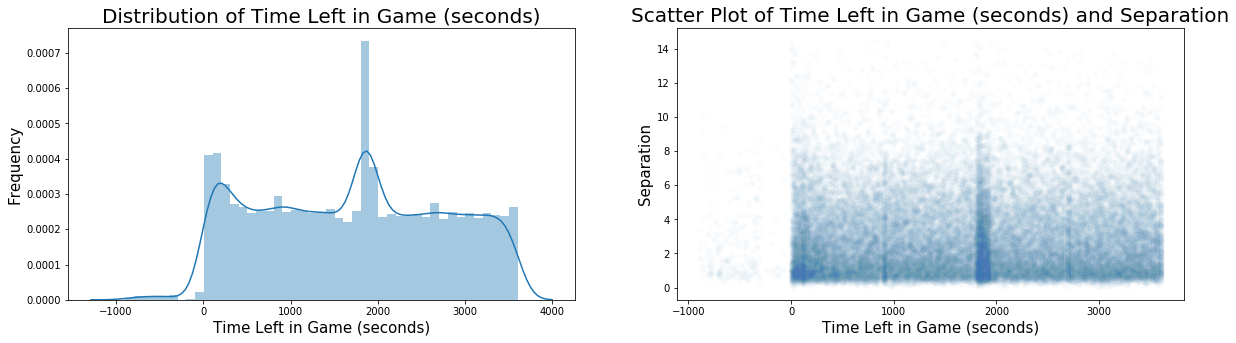

In [51]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(x, ax = ax1)
sns.scatterplot(x=x, y = y, alpha = 0.02)

ax1.set_title('Distribution of Time Left in Game (seconds)', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

ax2.set_title('Scatter Plot of Time Left in Game (seconds) and Separation', fontsize = 20)
ax2.set_ylabel('Separation', fontsize = 15)
A = ax2.set_xlabel('Time Left in Game (seconds)', fontsize = 15)

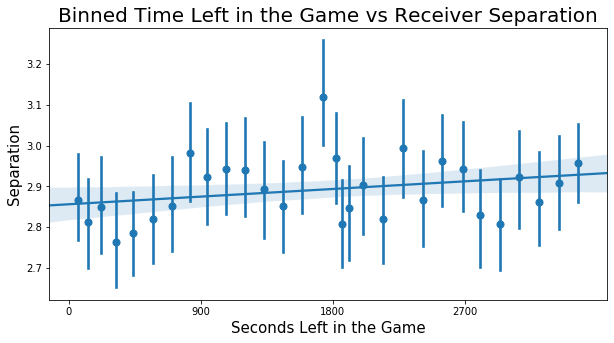

In [52]:
x = Merged['sec_left_in_game']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y, x_bins = 30)

ax.set_title('Binned Time Left in the Game vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 3600, step=900))
A = ax.set_xlabel('Seconds Left in the Game', fontsize = 15)

I cannot see any strong trends from the graph above, so let me take this a step further, by isolating time by halves.

## Feature Engineering: Time Left in Half

I would like to see if theres anything to the fact that 2 minute scenarios (ends of each half) might be more telling. I suspect that creating a new field called **_'time left in half'_** might be more insightful

In [53]:
mask = (Merged['Qtr'] == 1) | (Merged['Qtr'] == 3)
Merged['sec_left_in_half'] = Merged['Time_in_Sec']
Merged['sec_left_in_half'][mask] = Merged['Time_in_Sec'] + 900
Merged.head() 

,Nearest_Def_Position,Qtr,Time,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Time,TTT,...,Separation,YTG_Bin,Down_Distance,Cushion_Type,is_near_sideline,Inside_5YardLine,NDP,Time_in_Sec,sec_left_in_game,sec_left_in_half
51974,CB,2,9:28,3,1,Wide,2.71,6.06,0.668,2.602,...,3.614540,Short,3&Short,Press,1,0,CB,568,2368,568
37741,CB,4,14:20,1,1,Tight,2.67,9.70,1.214,4.488,...,1.223315,Short,1&Short,Press,0,1,CB,860,860,860
2336,CB,1,5:03,3,1,Slot,2.31,23.08,2.069,2.213,...,0.384708,Short,3&Short,Press,1,0,CB,303,3003,1203
37742,CB,4,14:14,2,1,Wide,3.14,6.25,1.989,1.142,...,1.276127,Short,2&Short,Regular,1,1,CB,854,854,854
3538,FS,2,15:00,3,1,Tight,6.20,3.99,1.067,3.137,...,11.414131,Short,3&Short,Regular,0,0,STY,900,2700,900


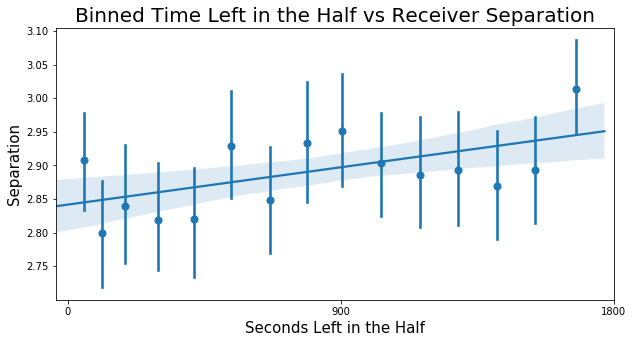

In [54]:
x = Merged['sec_left_in_half']
y = Merged['Separation']

fig, ax = plt.subplots(figsize = (10,5))
sns.regplot(x=x, y = y,  x_bins = 15)

ax.set_title('Binned Time Left in the Half vs Receiver Separation', fontsize = 20)
ax.set_ylabel('Separation', fontsize = 15)
plt.xticks(np.arange(0, 2700, step=900))
A = ax.set_xlabel('Seconds Left in the Half', fontsize = 15)

In [55]:
print('Spearman (rank) correlation: ' + str(round(x.corr(y, method = 'spearman'), 3)) + ' between Time and Separation')
print('Pearson (linear) correlation: ' + str(round(x.corr(y, method = 'pearson'), 3)) + ' between Time and Separation')

Spearman (rank) correlation: 0.023 between Time and Separation
Pearson (linear) correlation: 0.015 between Time and Separation


Turns out, this had little to **no effect** on my correlation values, but so it goes! I am going to try one more thing to see if it is potentially helpful. I am going to create a boolean for 'is_under_2_min' that checks whether the play comes with under 2 minuets left in the half.

## Feature Engineering: 2-Minute Drill? 

Does the pass come with under 2 minutes left in a half?

In [56]:
Merged['Under_2Min'] = 0
Merged['Under_2Min'].loc[Merged['sec_left_in_half'] <= 120] = 1

A = Merged['Under_2Min'].sum()
B = len(Merged)
C = round(((A/B)*100), 1)
print(str(A) + ' of ' + str(B) + ' targets came with under 2 min remaining in the half, or ' + str(C) + '% of all plays')

6273 of 43559 targets came with under 2 min remaining in the half, or 14.4% of all plays


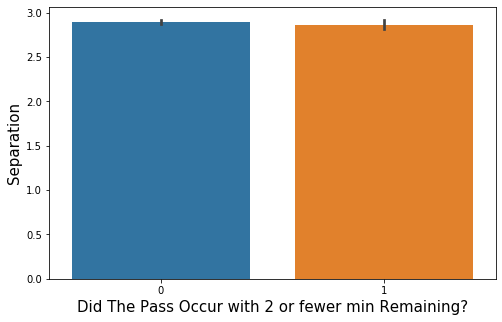

In [57]:
x = Merged['Under_2Min']
y = Merged['Separation']
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x=x, y=y)
ax.set_ylabel('Separation', fontsize = 15)
A = ax.set_xlabel('Did The Pass Occur with 2 or fewer min Remaining?', fontsize = 15)

Even after doing this work, unfortunately, **being under 2 min left in the half has almost no correlation** to receiver separation. 

# Feature Selection

We started with 17 raw feaures in the dataset, and we engineered 14 more features with the prosect of trying to create more insightful variables. Now with 30 features to sift through, let's dive in to the process of selecting the features that account for the most variance in the output variable (*Receiver Separation*)

I would like to note that it would be perfectly fine to use all 30 features and see how it all turns out, but when potentially dealing with linear regression modeling we should be wary that including unessary, co-variate, or redundant features would only cloud our predictions.

> _Many models, especially those based on regression slopes and intercepts, will estimate parameters for every term in the model. Because of this, the presence of non-informative variables can add uncertainty to the predictions and reduce the overall effectiveness of the model._
>
> Page 488, Applied Predictive Modeling, 2013.

In [58]:
#Time is a string, we don't need it now that we have it in seconds, let's drop it

Merged = Merged.drop('Time', axis = 1)
Merged = Merged.drop('Time_in_Sec', axis = 1)
Merged = Merged.drop('Nearest_Def_Position', axis = 1)
Merged = Merged.drop('sec_left_in_game', axis = 1)
Merged = Merged.drop('Under_2Min', axis = 1)

In [59]:
#Check to see how many null values there are left
Merged.to_pickle("../data/Cat.pkl")
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43559 entries, 51974 to 17558
Data columns (total 21 columns):
Qtr                            43559 non-null int64
Down                           43559 non-null int64
To Go                          43559 non-null int64
Receiver_Location              43559 non-null object
Cushion                        43559 non-null float64
Air_Yds                        43559 non-null float64
Air_Time                       43559 non-null float64
TTT                            43559 non-null float64
QB_Separation                  43559 non-null float64
QBP                            43559 non-null int64
Receiver_Dist_From_Sideline    43559 non-null float64
EZ_Dist                        43559 non-null float64
missing_cushion                43559 non-null int64
Separation                     43559 non-null float64
YTG_Bin                        43559 non-null object
Down_Distance                  43559 non-null object
Cushion_Type                   43559

## Encoding Categorical Variables

Before we can start doing any worthwhile analysis, we have to encode our categorical variables into numerical ones so our linear/ML models can begin to understand what they represent. To do this, we will **1-HOT ENCODE** all our categorical variables, creating a new column for each possible value within each category. This isnt necessarily the most effective or accurate way to encode our variables, but it is tried and true, and creates a good baseline. If we want to ensure no stone is unturn later, we can revisit other ways to encode each categorical variable.

In [60]:
# One Hot Encodes all labels before Machine Learning

Merged_Enc = pd.get_dummies(data = Merged)
print('We have', len(Merged_Enc.columns), 'features to help with predictions')
Merged_Enc.to_pickle("../data/Orig.pkl")

We have 46 features to help with predictions


### Handling Skewed Features/Log/Cube Root Transform

For linear models, an assumption that we make is that the features we select have a linear relationshup to the target variable. (Separation). Unfortunately, a lot of the features in my dataset do not relate to separation linearly. So, to encourage this behavior, we will apply a log transform to the skewed features, so that they behave more linearly in relation to out target variable. 

In fact, we will be using the log1p() NumPy funciton which adds 1 to every element of the feature before taking the log of it so that there are no errors at 0. 

In [61]:
#Make a copy of the dataframe
Merged_T = Merged_Enc.copy()

#log transform skewed numeric floating point (continuous) features:
float_cols = Merged_T.drop('Separation', axis =1).select_dtypes(include=['float64'])
float_cols = float_cols.columns

skewed_feats = Merged_T[float_cols].apply(lambda x: stats.skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > .50]
skewed_feats = skewed_feats.index

print('There are ' + str(len(skewed_feats)) + ' skewed features that needed to be log transformed')
print('The Skewed features were ' + str(list(skewed_feats)))

# Air Yards needs to be shifted before we log transform

Merged_T['Air_Yds'] = Merged_T['Air_Yds'] + 20

#Apply log(1+x) transform to all feaures with skewed distributions

Merged_Trans = Merged_T.copy()
Merged_Trans[skewed_feats] = np.log1p(Merged_Trans[skewed_feats])

There are 4 skewed features that needed to be log transformed
The Skewed features were ['Air_Yds', 'Air_Time', 'TTT', 'QB_Separation']


In [62]:
Merged_Trans[skewed_feats].describe()

,Air_Yds,Air_Time,TTT,QB_Separation
count,43559.000000,43559.000000,43559.000000,43559.000000
mean,3.390732,0.705204,1.269406,1.349348
std,0.292056,0.242439,0.247214,0.316490
min,1.238374,0.003992,0.261595,0.086686
25%,3.206398,0.527683,1.113829,1.148159
50%,3.347093,0.642380,1.262996,1.362587
75%,3.570940,0.835514,1.411475,1.559013
max,4.436988,1.720263,2.658860,2.697356


In [78]:
float_col = Merged.select_dtypes(exclude=['object'])
float_col = float_col.columns

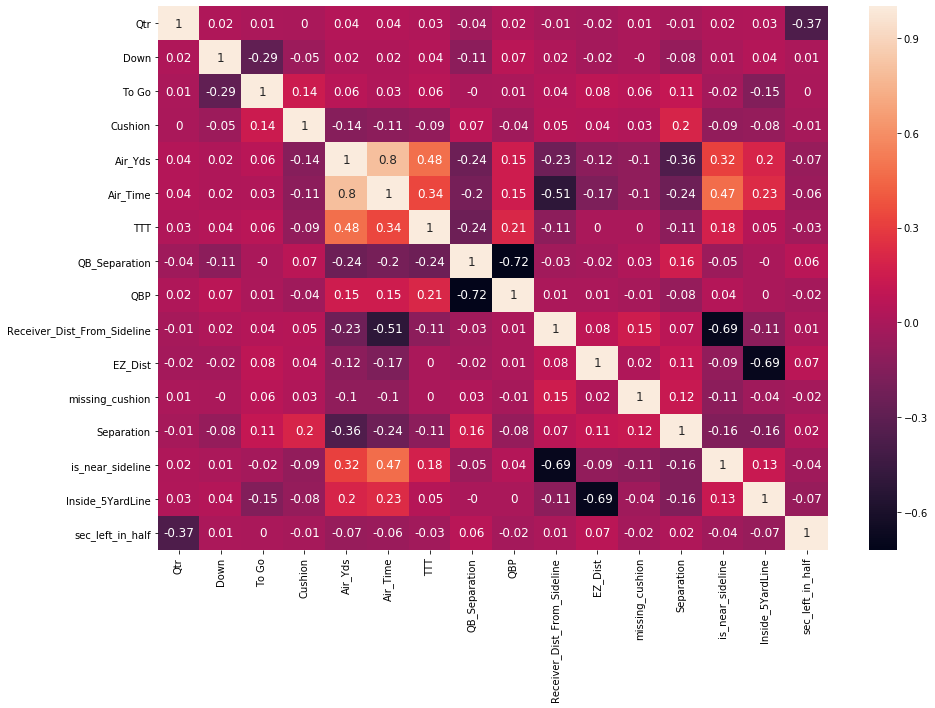

In [79]:
fig =  plt.subplots(figsize=(15,10))
ax = sns.heatmap(round(Merged_Trans[float_col].corr(method = 'pearson'), 2), annot=True, annot_kws={"size": 12})

After transforming out skewed features, the pearson (linear) correlation values for Air Yards and Time to throw have increased (.32 to .38 & .07 up to .11) but left the correlations to QB Separation and Air Time relativeley unchanged.

Since categorical features behave inherently non-continuously, we will use the **Kendall Tau** rank correlation metric to measure our categorical features relationship with Separation. 


In [84]:
Cat_cols = ['Receiver_Location_Slot', 'Receiver_Location_Tight',
       'Receiver_Location_Wide', 'YTG_Bin_Long', 'YTG_Bin_Longest',
       'YTG_Bin_Medium', 'YTG_Bin_Short','Cushion_Type_Off', 'Cushion_Type_Press',
       'Cushion_Type_Regular', 'NDP_CB', 'NDP_DL', 'NDP_LB', 'NDP_STY', 'Separation']

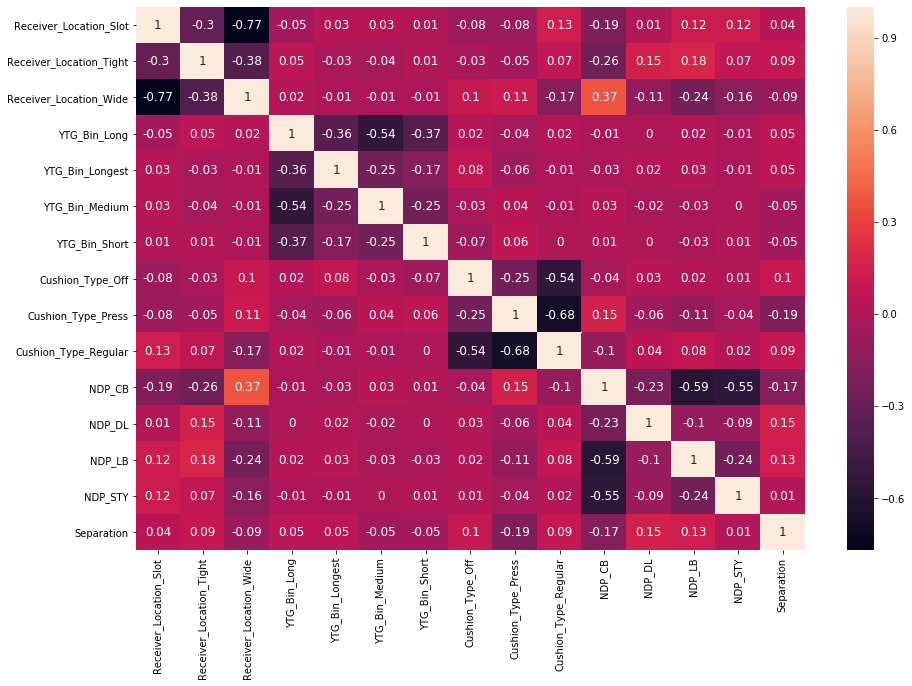

In [88]:
fig =  plt.subplots(figsize=(15,10))
ax = sns.heatmap(round(Merged_Trans[Cat_cols].corr(method = 'kendall'), 2), annot=True, annot_kws={"size": 12})

**Cushion_Type_Press** (-.19), **NDP_CB** (-.17), and **NDP_DL** (0.15) are the leading categorical candidates in influencing our final model. 

We can see how they affected my final model in the next notebook (Model Selection and Tuning)

In [65]:
Merged_Trans.to_pickle("../data/processed.pkl")